In [1]:
import geopandas as gpd
import pandas as pd
import h3
import shapely
from shapely import Polygon
import os
import warnings
warnings.filterwarnings("ignore")  # Silence some warnings

In [ ]:

new_df = pd.read_csv('h3_routing_dict.csv')
new_df

def get_all_possible(hex_cell, budget):
    neighbors = h3.k_ring(hex_cell, 1)
    list_available_cells = []
    list_budgets = []

    for h3_nejb in neighbors:
        try:
            h3_nejb_time = new_df[(new_df['from'] == hex_cell) & (new_df['to'] == h3_nejb)]['time'].values[0]
            if h3_nejb_time <= budget: # todo check h3 nejb time
                list_available_cells.append(h3_nejb)
                list_budgets.append(budget - h3_nejb_time)
        except:
            pass
            
    return list_available_cells, list_budgets


def get_trade_area(hex_cell, budget):
    list_trade_areas = []
    queue = [(hex_cell, budget)]  # Inicjalizuj kolejkę z komórką startową i budżetem

    while queue:
        current_hex_cell, current_budget = queue.pop(0)  # Pobierz pierwszy element z kolejki

        # Dodaj instrukcje print tutaj, aby śledzić aktualne wartości
        print(f"Obecna komórka: {current_hex_cell}, Pozostały budżet: {current_budget}")

        list_available_cells, list_budgets = get_all_possible(current_hex_cell, current_budget)

        # Wyświetl dostępne komórki
        print(f"Dostępne komórki: {list_available_cells}")

        # Filtruj komórki, które już zostały odwiedzone
        new_cells = [cell for cell in list_available_cells if cell not in list_trade_areas]

        # Wyświetl nowe komórki do odwiedzenia
        print(f"Nowe komórki do odwiedzenia: {new_cells}")

        # Dodaj nowe komórki do listy odwiedzonych obszarów
        list_trade_areas.extend(new_cells)

        # Dodaj nowe komórki do kolejki wraz z ich pozostałym budżetem
        queue.extend(zip(new_cells, list_budgets))

    return list_trade_areas


h3_start = h3.geo_to_h3(50.095, 19.9075, 8)

list_heks =[]
ta_gdf=pd.DataFrame()

for heks in set(get_trade_area(h3_start, 600)):
    heks_geom = h3.h3_to_geo_boundary(heks)
    gdf = gpd.GeoDataFrame(geometry=[Polygon(heks_geom)])
    list_heks.append(gdf)

gdf_ta = pd.concat(list_heks)
gdf_ta = gdf_ta.geometry.map(lambda polygon: shapely.ops.transform(lambda x, y: (y, x), polygon))



In [ ]:
def get_all_possible(hex_cell, budget):
    neighbors = h3.k_ring(hex_cell, 1)
    list_available_cells = []
    list_budgets = []

    for h3_nejb in neighbors:
        mask = (new_df['from'] == hex_cell) & (new_df['to'] == h3_nejb)
        if not new_df[mask].empty:
            h3_nejb_time = new_df[mask]['time'].values[0]
            if h3_nejb_time <= budget:
                list_available_cells.append(h3_nejb)
                list_budgets.append(budget - h3_nejb_time)
        else:
            print(f"Brak danych dla przejścia z {hex_cell} do {h3_nejb}")
    return list_available_cells, list_budgets

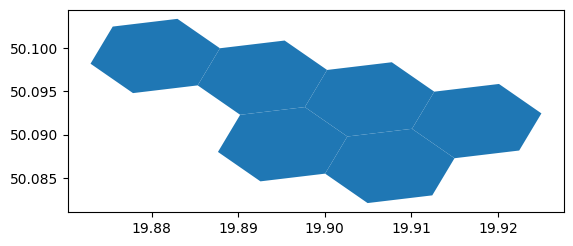

In [37]:
gdf_ta.plot()
# gdf_ta.to_file(os.path.join(folder_proj,'test_krk.shp'))